# FLEXÃO NORMAL SIMPLES - DIFERENTES DIAGRAMAS PARA O CONCRETO


Este arquivo apresenta uma tentativa de implementar em código Python os exemplos apresentados no capítulo 1 do livro Curso de Concreto Armado - Tópicos Avançados, de José Milton Araújo.

O livro pode ser adquirido no seguinte link: https://www.editoradunas.com.br/volume7.html



## 1.1 INTRODUÇÃO

Diversos documentos normativos admitem diferentes modelos para representar o diagrama tensão–deformação do concreto no dimensionamento estrutural. Publicações como o Eurocode 2 e o fib Model Code 2010 permitem o uso dos três diagramas clássicos: parábola–retângulo, bilinear e retangular. De forma semelhante, o ACI também admite esses três modelos, apresentando apenas pequenas variações na formulação do diagrama parábola–retângulo.

No Brasil, a NBR 6118:2023 permite a utilização tanto do diagrama parábola–retângulo quanto do diagrama retangular equivalente.

Diante da possibilidade de uso de múltiplas curvas tensão-deformação, o objetivo deste código é comparar os resultados obtidos pelos diagramas parábola–retângulo, bilinear e retangular — avaliando suas semelhanças, diferenças e impacto no dimensionamento estrutural.

In [33]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

## 1.2 Diagramas tensão-deformação para o concreto
### a) Diagrama parábola-retângulo

Nas verificações de seções transversais à flexão simples ou composta, a NBR 6118/2014 adota o diagrama parábola-retângulo.

<figure style="text-align: center;">
    <img src="ParabolaRetangulo.png" width="480">
    <figcaption><strong>Figura 1 –</strong> Diagrama tensão–deformação parábola–retângulo.</figcaption>
</figure>


O diagrama tensão-deformação é descrito pelas seguintes expressões:

$$
\sigma_c(\varepsilon_c)=
\begin{cases}
0.85\,f_{cd}\left[1-\left(1-\dfrac{\varepsilon_c}{\varepsilon_o}\right)^{n}\right], 
&\varepsilon_c \le \varepsilon_o\\[10pt]
0.85\,f_{cd}, 
& \varepsilon_o < \varepsilon_c \le \varepsilon_u
\end{cases}
$$

Os valores a serem adotados para o parâmetro $\varepsilon_{c2}$, deformação específica de encurtamento do concreto no início do patamar plástico, são:

$$
\varepsilon_{c2}\,(\text{‰})=
\begin{cases}
2.0, 
& f_{ck} \le 50\ \text{MPa} \\[6pt]
2.0 + 0.085\,(f_{ck}-50)^{0.53}, 
& f_{ck} > 50\ \text{MPa}
\end{cases}
$$

Para os valores de $\varepsilon_{u}$, deformação específica de encurtamento do concreto na ruptura, adota-se:

$$
\varepsilon_{u}\,(\text{‰})=
\begin{cases}
3.5, 
& f_{ck} \le 50\ \text{MPa} \\[6pt]
2.6 + 35\left(\dfrac{90 - f_{ck}}{100}\right)^{4},
& f_{ck} > 50\ \text{MPa}
\end{cases}
$$

Por fim, para os valores do expoente \( n \), utiliza-se:

$$
n =
\begin{cases}
2.0,
& f_{ck} \le 50\ \text{MPa} \\[6pt]
1.4 + 23.4\left(\dfrac{90 - f_{ck}}{100}\right)^{4},
& f_{ck} > 50\ \text{MPa}
\end{cases}
$$

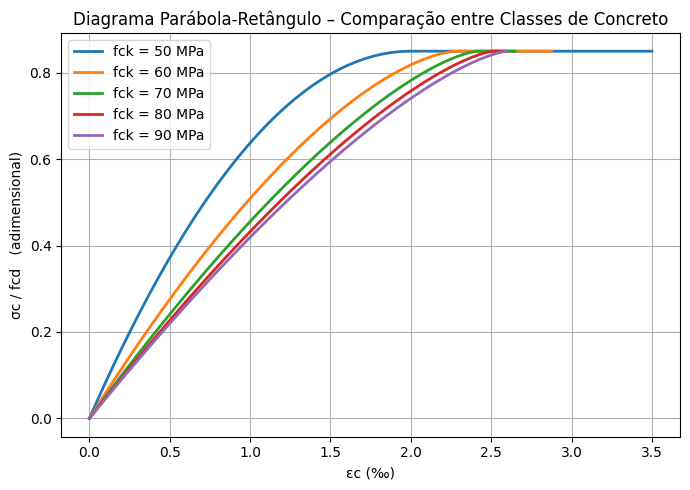

In [34]:
def parabola_retangulo(fck):
    if fck <= 50:
        eo, eu, n = 2.0, 3.5, 2.0
    else:
        eo = 2.0 + 0.085 * (fck - 50)**0.53
        eu = 2.6 + 35 * ((90 - fck) / 100)**4
        n  = 1.4 + 23.4 * ((90 - fck) / 100)**4
    return eo/1000, eu/1000, n      # converte ‰ → adimensional

def sig(ec, fck):
    eo, eu, n = parabola_retangulo(fck)
    ec2 = eo

    # garante que na parábola nunca entra ec > ec2
    ec_eff = np.minimum(ec, ec2)

    sig = 0.85*(1 - (1 - ec_eff/ec2)**n)
    sig = np.where(ec > ec2, 0.85, sig)   # patamar
    sig = np.where(ec > eu,  np.nan, sig) # corte na ruptura
    return sig


ec = np.linspace(0, 0.0035, 400)

plt.figure(figsize=(7,5))
for fck in [50,60,70,80,90]:
    plt.plot(ec*1000, sig(ec,fck), label=f"fck = {fck} MPa", linewidth=2)

plt.xlabel("εc (‰)")
plt.ylabel("σc / fcd   (adimensional)")
plt.title("Diagrama Parábola-Retângulo – Comparação entre Classes de Concreto")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### b) Diagrama bilinear

<figure style="text-align: center;">
    <img src="Bilinear.png" width="480">
    <figcaption><strong>Figura 2 –</strong> Diagrama tensão–deformação bilinear.</figcaption>
</figure>

Nesse diagrama, utiliza-se $\varepsilon_{01}$ como a deformação específica correspondente ao início do patamar plástico.  
Os valores recomendados são:

$$
\varepsilon_{01}\,(\text{‰}) =
\begin{cases}
1.75, 
& f_{ck} \le 50\ \text{MPa} \\[6pt]
1.75 + 0.55\left(\dfrac{f_{ck} - 50}{40}\right),
& f_{ck} > 50\ \text{MPa}
\end{cases}
$$

A deformação última $\varepsilon_u$ coincide com aquela adotada no diagrama parábola–retângulo, variando conforme a resistência do concreto.



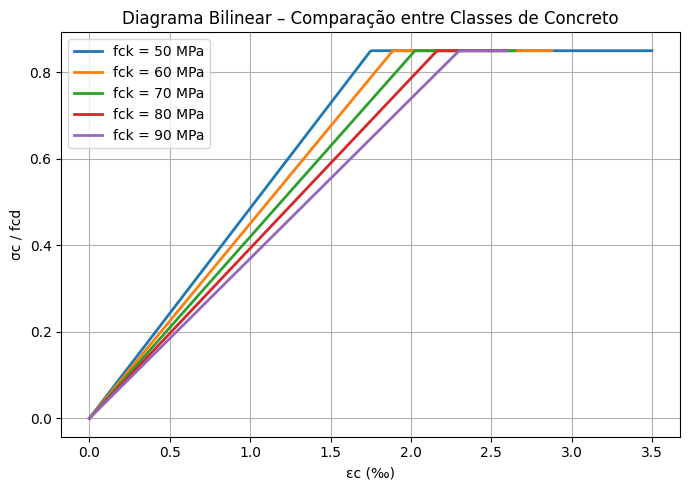

In [35]:
def bilinear(fck):
    if fck <= 50:
        eo, eu = 1.75, 3.5
    else:
        eo = 1.75 + 0.55*(fck-50)/40
        eu = 2.6 + 35*((90-fck)/100)**4
    return eo/1000, eu/1000          # converte ‰ → adimensional

def sig_bi(ec, fck):
    eo, eu = bilinear(fck)
    k = 0.85/eo
    sig = np.where(ec <= eo, k*ec, 0.85)      # linear até εo1
    sig = np.where(ec > eu, np.nan, sig)     # corta na ruptura
    return sig

ec = np.linspace(0, 0.004, 400)

plt.figure(figsize=(7,5))
for fck in [50,60,70,80,90]:
    plt.plot(ec*1000, sig_bi(ec,fck), label=f"fck = {fck} MPa", linewidth=2)

plt.xlabel("εc (‰)")
plt.ylabel("σc / fcd")
plt.title("Diagrama Bilinear – Comparação entre Classes de Concreto")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### c) Diagrama retangular

<figure style="text-align: center;">
    <img src="Retnagulo.png" width="480">
    <figcaption><strong>Figura 3 –</strong> Diagrama tensão–deformação retangular simplificado.</figcaption>
</figure>

Conforme se observa na figura, admite-se que a tensão no concreto seja igual a  
$\sigma_{cd} = \alpha_c f_{cd}$ desde a borda comprimida até uma distância $\lambda x$, sendo $x$ a profundidade da linha neutra.

O coeficiente $\alpha_c$ é dado por:


$$
\alpha_c =
\begin{cases}
0.85, 
& f_{ck} \le 50 \text{ MPa} \\[6pt]
0.85\left[1 - \dfrac{f_{ck} - 50}{200}\right],
& f_{ck} > 50 \text{ MPa}
\end{cases}
$$

Já o parâmetro $\lambda$ é definido como:

$$
\lambda =
\begin{cases}
0.80, 
& f_{ck} \le 50 \text{ MPa} \\[6pt]
0.80 - \dfrac{f_{ck} - 50}{400},
& f_{ck} > 50 \text{ MPa}
\end{cases}
$$


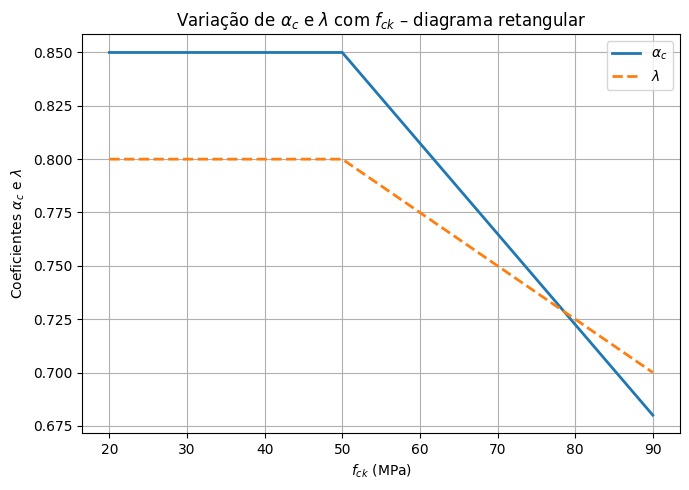

In [36]:
def retangular(fck):
    if fck <= 50:
        alfac = 0.85
        lbd   = 0.80
    else:
        alfac = 0.85 * (1 - (fck - 50)/200)
        lbd   = 0.80 - (fck - 50)/400
    return alfac, lbd

fck_vals = np.linspace(20, 90, 71)
alfas, lambdas = [], []

for f in fck_vals:
    a, l = retangular(f)
    alfas.append(a)
    lambdas.append(l)

plt.figure(figsize=(7,5))
plt.plot(fck_vals, alfas,  label=r"$\alpha_c$", linewidth=2)
plt.plot(fck_vals, lambdas, label=r"$\lambda$", linewidth=2, linestyle="--")
plt.xlabel(r"$f_{ck}$ (MPa)")
plt.ylabel(r"Coeficientes $\alpha_c$ e $\lambda$")
plt.title(r"Variação de $\alpha_c$ e $\lambda$ com $f_{ck}$ – diagrama retangular")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## 1.3 DEMAIS HIPÓTESES

### a) Módulo de Elasticidade do Aço
<figure style="text-align: center;">
    <img src="Aço.png" width="480">
    <figcaption><strong>Figura 3 –</strong> Diagrama tensão–deformação retangular simplificado.</figcaption>
</figure>

Para o diagrama de tensão–deformação do aço, considera-se o gráfico bilinear conforme apresentado na figura. No entanto, o autor adota o módulo de elasticidade como sendo $E_s = 200 \, \text{GPa}$ diferentemente do valor recomendado pela NBR 6118 $E_s = 210 \, \text{GPa}$.

Essa diferença gera uma leve alteração no valor considerado para o escoamento do aço, $\varepsilon_{yd}$ , e consequentemente na posição da linha neutra no ponto que define a fronteira entre os domínios 3 e 4 (em torno de 2%).

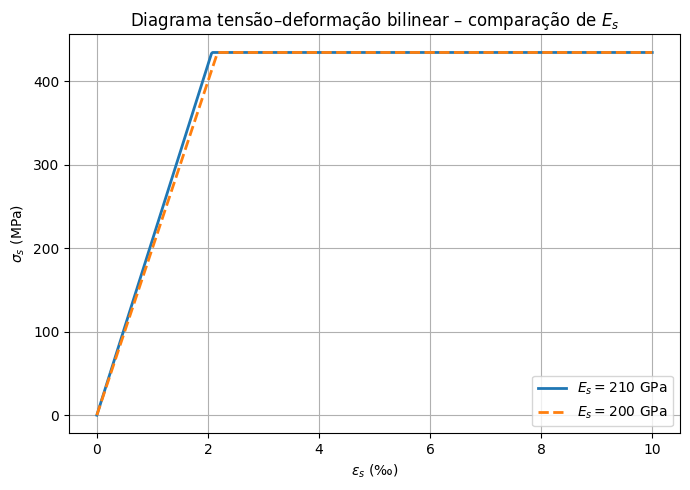

       Es epsilon_yd (‰)       C50       C60       C70       C80       C90
  200 GPa       2.173913  0.616858  0.571551   0.55397  0.544627  0.544627
  210 GPa       2.070393  0.628322  0.583455  0.565991  0.556698  0.556698
Diferença                    1.82%     2.04%     2.12%     2.17%     2.17%


In [ ]:
# dados do aço
fyk = 500.0               # MPa
gamma_s = 1.15
fyd = fyk / gamma_s       # MPa
eps_u = 10/1000           # 10 ‰

def diagrama_aco(Es_GPa):
    Es = Es_GPa * 1000.0                    # MPa
    eps_yd = fyd / Es                       # deformação de escoamento (adimensional)
    eps = np.linspace(0, eps_u, 500)
    sig = np.where(eps <= eps_yd, Es*eps, fyd)
    return eps, sig, eps_yd

# curvas para 210 e 200 GPa
eps_210, sig_210, eps_yd_210 = diagrama_aco(210)
eps_200, sig_200, eps_yd_200 = diagrama_aco(200)

plt.figure(figsize=(7,5))
plt.plot(eps_210*1000, sig_210, label=r"$E_s = 210$ GPa", linewidth=2)
plt.plot(eps_200*1000, sig_200, label=r"$E_s = 200$ GPa", linewidth=2, linestyle="--")

plt.xlabel(r"$\varepsilon_s$ (‰)")
plt.ylabel(r"$\sigma_s$ (MPa)")
plt.title("Diagrama tensão–deformação bilinear – comparação de $E_s$")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# Tabela comparativa
# ---------------------------------------------------------

eu_list = [3.5, 2.9, 2.7, 2.6, 2.6]   # valores de εu (‰) – C50, C60, C70, C80, C90
classes = ["C50", "C60", "C70", "C80", "C90"]

eps_yd_210_mil = eps_yd_210 * 1000   # em ‰
eps_yd_200_mil = eps_yd_200 * 1000   # em ‰

xi_200 = [eu/(eu + eps_yd_200_mil) for eu in eu_list]
xi_210 = [eu/(eu + eps_yd_210_mil) for eu in eu_list]
dif_pct = [(x210 - x200)/x210*100 for x200, x210 in zip(xi_200, xi_210)]

df = pd.DataFrame(
    {
        "Es": ["200 GPa", "210 GPa", "Diferença"],
        "epsilon_yd (‰)": [eps_yd_200_mil, eps_yd_210_mil, ""],
        **{
            cls: [round(x200, 6), round(x210, 6), f"{d:.2f}%" ]
            for cls, x200, x210, d in zip(classes, xi_200, xi_210, dif_pct)
        }
    }
)

print(df.to_string(index=False))


### b) Posição da linha neutra

<figure style="text-align: center;">
    <img src="LinhaNeutra.png" width="480">
    <figcaption><strong>Figura 3 –</strong> Diagrama tensão–deformação retangular simplificado.</figcaption>
</figure>

Para garantir uma boa ductilidade da peça, as normas de projeto limitam a profundidade da linha neutra a:

$$
x \le x_{\text{lim}}
$$

Elimina-se, assim, a parte final do domínio 3, onde a deformação na armadura mais tracionada é muito próxima da deformação de escoamento.  

Por esse motivo, o dimensionamento à flexão simples fica restrito ao domínio 2 e à parte inicial do domínio 3, como ilustrado na figura e expresso pelas equações abaixo.


$$
x_{\text{lim}} =
\begin{cases}
0{.}45, & \text{se } f_{ck} \le 50\ \text{MPa} \\[6pt]
0{.}35, & \text{se } f_{ck} > 50\ \text{MPa}
\end{cases}
$$

In [38]:
def xmax(fck):
    if fck <= 50:
        xlim = 0.45
    else:
        xlim = 0.35
    return xlim

### c) Armadura mínima

#### Armadura mínima entre os Estádios I e II

A definição de uma armadura mínima não decorre apenas do dimensionamento ao Estado Limite Último, mas também da necessidade de evitar uma ruptura brusca durante a transição do Estádio I (seção não fissurada) para o Estádio II (seção fissurada). Segundo José Milton Araújo, a verificação inicia-se pela resistência à tração da seção no Estádio I.

#### Estádio I

<figure style="text-align: center;">
    <img src="EstadioI.png" width="480">
    <figcaption><strong>Figura 4 –</strong> Seção de concreto simples no estádio I</figcaption>
</figure>

A resultante resistente à tração é:

$\displaystyle R_{ct}=\frac{(b\,h/2)\,\sigma_{ct}}{2}
=\frac{b\,h\,\sigma_{ct}}{4}$

Adotando-se o braço de alavanca $Z_1=\frac{2h}{3}$, o momento resistente torna-se:

$\displaystyle M_r=\frac{b\,h^2\,f_{ct}}{6}$

#### Estádio II

<figure style="text-align: center;">
    <img src="EstadioII.png" width="480">
    <figcaption><strong>Figura 5 –</strong> Seção de concreto armado no estádio II</figcaption>
</figure>

A área mínima de armadura é calculada por:

$\displaystyle A_{s,\min}=\frac{M_r}{Z_2\,f_{yd}}
=\frac{b\,h^2\,f_{ct}}{6\,Z_2\,f_{yd}}$

Como se adota $Z_2=\frac{5h}{6}$:

$\displaystyle A_{s,\min}=\frac{b\,h^2\,f_{ct}}{6\,(5h/6)\,f_{yd}}
=\frac{f_{ct}\,b\,h}{5\,f_{yd}}$

Definindo $A_c=b\,h$, $\rho=A_s/A_c$ e adotando  
$f_{ct}=f_{ctk,\text{sup}}=1{,}3\,f_{ctm}$ com:

$\displaystyle 
f_{ctm}=
\begin{cases}
0{,}3\,f_{ck}^{2/3}, & f_{ck}\leq 50\;\text{MPa} \\
2{,}12\,\ln(1+0{,}11f_{ck}), & f_{ck}\geq 55\;\text{MPa}
\end{cases}
$

obtém-se:

$\displaystyle 
\rho_{\min}=
\begin{cases}
\dfrac{0{,}078\,f_{ck}^{2/3}}{f_{yd}}, & f_{ck}\leq 50\;\text{MPa}\\[6pt]
\dfrac{0{,}5512\,\ln(1+0{,}11f_{ck})}{f_{yd}}, & f_{ck}\geq 55\;\text{MPa}
\end{cases}
$

---

#### Proposta da NBR 6118

A norma define o momento mínimo:

$\displaystyle M_{d,\min}=0{,}8\,W_0\,f_{ctk,\text{sup}}$

Para uma seção retangular, com os parâmetros adimensionais de Carvalho (2014):

$\displaystyle K_{MD}=\frac{M_d}{b_w\,d^2\,f_{cd}}$

$\displaystyle 
K_x=\frac{1-\sqrt{1-\frac{2\,K_{MD}}{\alpha_c}}}{\lambda}
=\frac{1-\sqrt{1-\frac{2\,M_d}{b_w\,d^2\,f_{cd}\,\alpha_c}}}{\lambda}
$

$\displaystyle 
K_z=1-\frac{\lambda}{2}K_x
=\frac{1}{2}+\frac{1}{2}\sqrt{1-\frac{2\,M_d}{b_w\,d^2\,f_{cd}\,\alpha_c}}
$

A área de aço é:

$\displaystyle A_s=\frac{M_d}{K_z\,d\,f_{yd}}$

Substituindo $M_d=0{,}8\,b\,h^2\,f_{ctk,\text{sup}}/6$ e tomando $b=h=1$:

$\displaystyle
\rho_s=
\frac{f_{ctk,\text{sup}}}{
\left(
\frac12+
\frac12\sqrt{
1-\frac{1{,}6\,f_{ctk,\text{sup}}}{3{,}84\,f_{cd}\,\alpha_c}
}
\right)
6\,f_{yd}}
$

---

#### Comparação entre versões da NBR 6118

As taxas mínimas de armadura prescritas pelas versões 2014 e 2023 da NBR 6118 são inferiores às propostas na edição 2003. Embora a origem precisa dos valores da edição antiga não seja explícita, o índice $\omega=0{,}035$ para seções retangulares sugere que os valores possam ter sido obtidos por ábacos como os de Montoya e Venturini.

Assim, considerando:

$\displaystyle \omega=\frac{A_s\,f_{yd}}{A_c\,f_{cd}}$

tem-se:

$\displaystyle \rho_{\min}=\frac{A_s}{A_c}
=\frac{f_{cd}\,\omega}{f_{yd}}
$


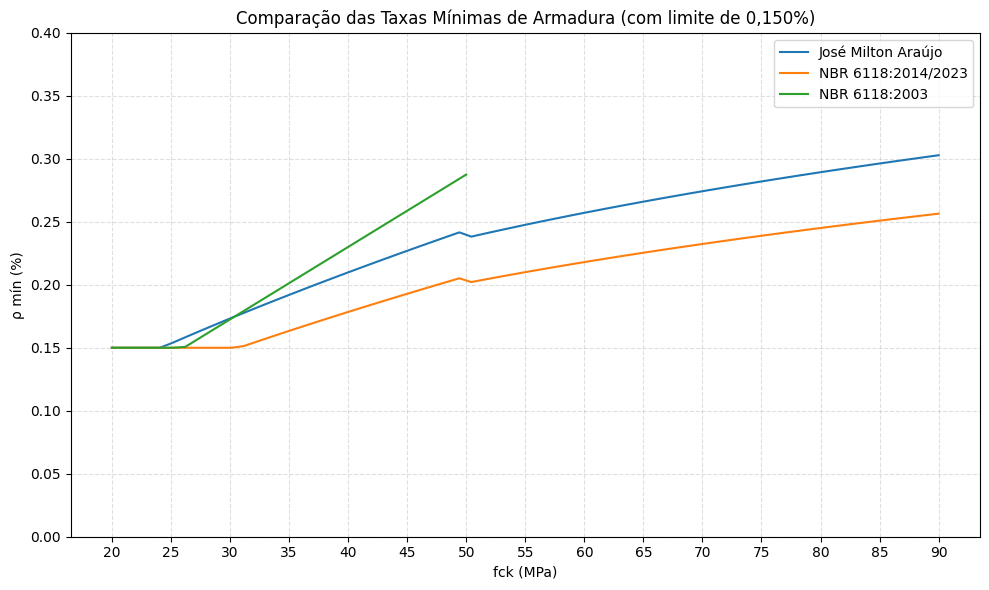

In [43]:
def amin_jma(fck):
    fyd = 500 / 1.15
    if fck <= 50:
        rho = 0.078 * fck**(2/3) / fyd
    else:
        rho = 0.5512 * np.log(1 + 0.11 * fck) / fyd
    return max(rho, 0.00150)

def amin_2014(fck):
    fyd = 500 / 1.15
    fcd = fck / 1.4

    if fck <= 50:
        fctm = 0.3 * fck**(2/3)
        fctksup = 1.3 * fctm
        alfac = 0.85
    else:
        fctm = 2.12 * np.log(1 + 0.11 * fck)
        fctksup = 1.3 * fctm
        alfac = 0.85 * (1 - (fck - 50) / 200)

    termoraiz = 1 - (1.6 * fctksup) / (3.84 * fcd * alfac)
    kz = 0.5 + 0.5 * math.sqrt(termoraiz)

    rho = fctksup / (kz * 6 * fyd)
    return max(rho, 0.00150)

def amin_2003(fck):
    fcd = fck / 1.4
    fyd = 500 / 1.15
    rho = 0.035 * fcd / fyd
    return max(rho, 0.00150)

# Vetorização das funções
v_amin_jma = np.vectorize(amin_jma)
v_amin_2014 = np.vectorize(amin_2014)
v_amin_2003 = np.vectorize(amin_2003)

# Faixas de fck
fck_vals1 = np.linspace(20, 90, 70)
fck_vals2 = np.linspace(20, 50, 30)

# Cálculo das três curvas (em %)
asjoma = v_amin_jma(fck_vals1) * 100
as2014 = v_amin_2014(fck_vals1) * 100
as2003 = v_amin_2003(fck_vals2) * 100

# Plot
plt.figure(figsize=(10,6))
plt.plot(fck_vals1, asjoma, label="José Milton Araújo")
plt.plot(fck_vals1, as2014, label="NBR 6118:2014/2023")
plt.plot(fck_vals2, as2003, label="NBR 6118:2003")

plt.xlabel("fck (MPa)")
plt.ylabel("ρ mín (%)")
plt.title("Comparação das Taxas Mínimas de Armadura (com limite de 0,150%)")

# Grades customizadas
plt.grid(True, which="both", linestyle="--", alpha=0.4)

# Grid no eixo x a cada 5 MPa
plt.xticks(np.arange(20, 95, 5))

# Grid no eixo y a cada 0,05%
plt.yticks(np.arange(0.0, max(asjoma.max(), as2014.max(), as2003.max()) + 0.1, 0.05))

plt.legend()
plt.tight_layout()
plt.show()



## 1.4 DETERMINAÇÃO DO MOMENTO LIMITE

### a) Compressão Limite No Concreto

A resultante de compressão no concreto (rcc) é valor adimensional correspondente à parcela comprimida da seção em análise. 

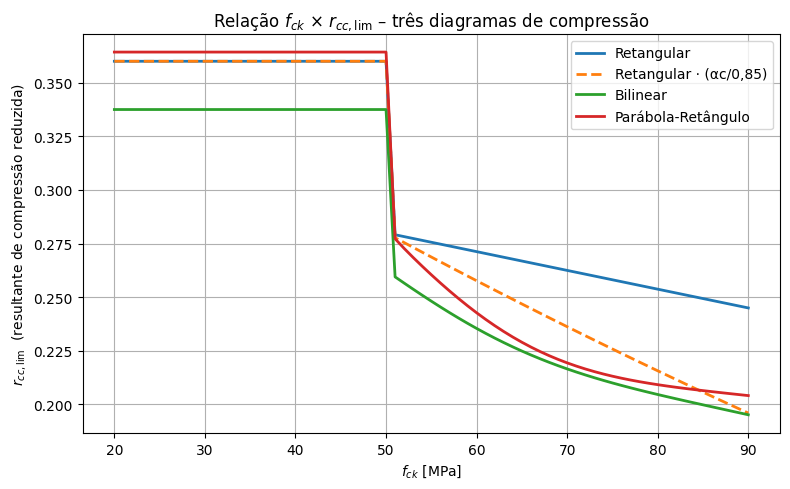

In [47]:
# ------------------------------
# Curva 1 - Retangular
# ------------------------------

def retangular(fck):
    if fck <= 50:
        alfac = 0.85
        lbd   = 0.80
    else:
        alfac = 0.85 * (1 - (fck - 50)/200)
        lbd   = 0.80 - (fck - 50)/400
    return alfac, lbd

def mdlim_ret(fck):
    alfac, l0 = retangular(fck)
    csi_lim   = xmax(fck)
    rcc_lim   = l0 * csi_lim
    mi_lim    = l0 * csi_lim * (1 - 0.5 * l0 * csi_lim)
    return csi_lim, rcc_lim, mi_lim

# ------------------------------
# Curva 2 - Bilinear
# ------------------------------

def bilinear(fck):
    if fck <= 50:
        eo = 1.75      # ‰
        eu = 3.50      # ‰
    else:
        eo = 1.75 + 0.55 * (fck - 50) / 40
        eu = 2.6 + 35 * ((90 - fck) / 100)**4
    return eo/1000, eu/1000   # converte ‰ → adimensional

def mdlim_bili(fck):
    eo, eu = bilinear(fck)

    csi_lim = xmax(fck)
    csi_0   = eo / eu
    l0      = 1 - csi_0

    rc1 = 0.5 * (1 - l0) * csi_lim
    rc2 = l0   * csi_lim
    rcc_lim = rc1 + rc2

    mi_c1 = rc1 * (1 - (1 + 2*l0) * csi_lim / 3)
    mi_c2 = rc2 * (1 - 0.5 * l0 * csi_lim)
    mi_lim = mi_c1 + mi_c2

    return csi_lim, rcc_lim, mi_lim


# ------------------------------
# Curva 3 - Parábola-Retângulo
# ------------------------------

def parabola_retangulo(fck):
    if fck <= 50:
        eo = 2.0       # ‰
        eu = 3.5       # ‰
        n1 = 2.0
    else:
        eo = 2.0 + 0.085 * (fck - 50)**0.53
        eu = 2.6 + 35 * ((90 - fck) / 100)**4
        n1 = 1.4 + 23.4 * ((90 - fck) / 100)**4
    return eo/1000, eu/1000, n1   # também em adimensional

def mdlim_parret(fck):
    eo, eu, n1 = parabola_retangulo(fck)

    csi_lim = xmax(fck)
    csi_0   = eo / eu
    l0      = 1 - csi_0

    rc1 = csi_0 * csi_lim * n1 / (n1 + 1)
    rc2 = l0 * csi_lim
    rcc_lim = rc1 + rc2

    mi_c1 = (csi_0 * csi_lim * (1 - csi_lim) * n1 / (n1 + 1)
             + (csi_0 * csi_lim)**2 * (0.5 - 1 / ((n1 + 1) * (n1 + 2))))
    mi_c2 = l0 * csi_lim * (1 - 0.5 * l0 * csi_lim)
    md_lim = mi_c1 + mi_c2

    return csi_lim, rcc_lim, rc1, rc2, md_lim

# ------------------------------
# Gráfico: fck × compressão máxima r_cc,lim
# com curva retangular ajustada por (αc / 0,85)
# ------------------------------

fck_vals = np.linspace(20, 90, 71)

rcc_ret_vals      = []
rcc_ret_alf_vals  = []
rcc_bili_vals     = []
rcc_pare_vals     = []

for fck in fck_vals:
    # retangular original
    alfac, lbd = retangular(fck)
    csi_lim    = xmax(fck)
    rcc_r      = lbd * csi_lim

    # retangular ajustado pela razão αc / 0,85
    rcc_r_alf  = rcc_r * (alfac / 0.85)

    # bilinear e parábola-retângulo
    _, rcc_b, _           = mdlim_bili(fck)
    _, rcc_p, _, _, _     = mdlim_parret(fck)

    rcc_ret_vals.append(rcc_r)
    rcc_ret_alf_vals.append(rcc_r_alf)
    rcc_bili_vals.append(rcc_b)
    rcc_pare_vals.append(rcc_p)

plt.figure(figsize=(8,5))
plt.plot(fck_vals, rcc_ret_vals,      label="Retangular", linewidth=2)
plt.plot(fck_vals, rcc_ret_alf_vals,  label="Retangular · (αc/0,85)", linewidth=2, linestyle="--")
plt.plot(fck_vals, rcc_bili_vals,     label="Bilinear",   linewidth=2)
plt.plot(fck_vals, rcc_pare_vals,     label="Parábola-Retângulo", linewidth=2)

plt.xlabel(r"$f_{ck}$ [MPa]")
plt.ylabel(r"$r_{cc,\mathrm{lim}}$  (resultante de compressão reduzida)")
plt.title(r"Relação $f_{ck}$ × $r_{cc,\mathrm{lim}}$ – três diagramas de compressão")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### b) Momento Limite

O momento limite, assim como o valor de compressão limite, é o valor adimensional correspondente ao momento resistido pela seção em análise. 

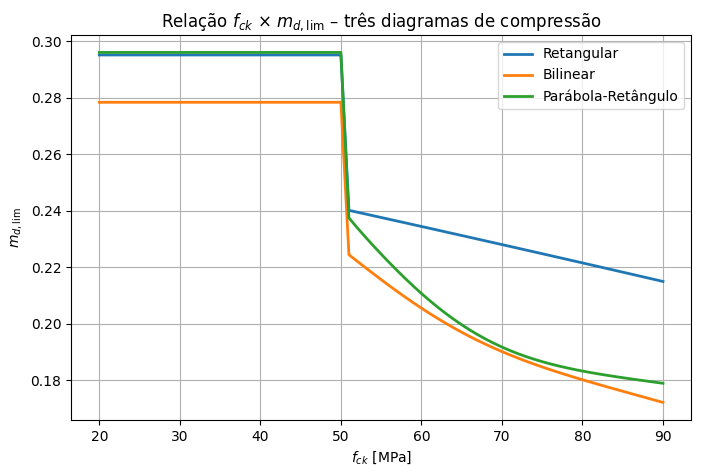

In [48]:
# ------------------------------
# Gráfico: fck × momento reduzido
# ------------------------------

fck_vals = np.linspace(20, 90, 71)

mi_ret_vals  = []
mi_bili_vals = []
mi_pare_vals = []

for fck in fck_vals:
    _, _, mi_r   = mdlim_ret(fck)
    _, _, mi_bi  = mdlim_bili(fck)
    _, _, _, _, mi_pr = mdlim_parret(fck)   # agora desempacota os 5 valores

    mi_ret_vals.append(mi_r)
    mi_bili_vals.append(mi_bi)
    mi_pare_vals.append(mi_pr)

plt.figure(figsize=(8,5))
plt.plot(fck_vals, mi_ret_vals,  label="Retangular", linewidth=2)
plt.plot(fck_vals, mi_bili_vals, label="Bilinear",   linewidth=2)
plt.plot(fck_vals, mi_pare_vals, label="Parábola-Retângulo", linewidth=2)

plt.xlabel(r"$f_{ck}$ [MPa]")
plt.ylabel(r"$m_{d,\mathrm{lim}}$")
plt.title(r"Relação $f_{ck}$ × $m_{d,\mathrm{lim}}$ – três diagramas de compressão")
plt.grid(True)
plt.legend()
plt.show()

## 1.5 DIMENSIONAMENTO COM ARMADURA SIMPLES

Se o momento fletor solicitante de cálculo for menor ou igual ao momento limite, o dimensionamento é feito com armadura simples e a seção será subarmada ou normalmente armada. A profundidade da linha neutra será menor ou igual a xlim e a ruína ocorrerá no domínio 2 ou 3.

## 1.6 Dimensionamento com Armadura Dupla

Se o momento fletor solicitante de cálculo for maior que o momento limite, a profundidade da linha neutra é fixada como sendo igual a $x_{\text{lim}}$, acrescentando-se uma armadura de compressão com área $A_s'$.

Considerando:

$$
x_{\text{lim}} = \zeta_{\text{lim}}\, d
$$

$$
\delta = \frac{d'}{d}
$$

Então:

$$
\varepsilon_s' = 
\varepsilon_u \left( \frac{\zeta_{\text{lim}} - \delta}{\zeta_{\text{lim}}} \right)
$$

Fazendo o equilíbrio de momentos em relação ao centróide da armadura tracionada, resulta:

$$
M_d - R'_{sd}(d - d') - R_{cc,\text{lim}}\, z_{\text{lim}} = 0
$$

$$
A_s' =
\frac{M_d - M_{d,\text{lim}}}{(d - d')\, \sigma'_{sd}}
$$

Definindo a taxa de armadura:

$$
\rho' = \frac{A_s'}{b\, d}
$$

e introduzindo os adimensionais, chega-se a:

$$
\rho' =
\frac{(\mu - \mu_{\text{lim}})\, \sigma_{cd}}
{(1 - \delta)\, \sigma'_{sd}}
$$

Para o equilíbrio das forças:

$$
R_{sd} = R'_{sd} + R_{cc,\text{lim}}
$$

e

$$
A_s =
\frac{
A_s'\, \sigma_{sd}
+
R_{cc,\text{lim}}\, b\, d\, \sigma_{cd}
}{
f_{yd}
}
$$

Definindo a taxa de armadura como sendo:

$$
\rho = \frac{A_s}{b\, d}
$$

obtém-se:

$$
\rho =
\left(
r_{cc,\text{lim}}
+
\frac{\mu - \mu_{\text{lim}}}{1 - \delta}
\right)
\left(
\frac{\sigma_{cd}}{f_{yd}}
\right)
$$


## 1.7 RESULTADOS OBTIDOS COM OS TRÊS DIAGRAMAS PARA O CONCRETO

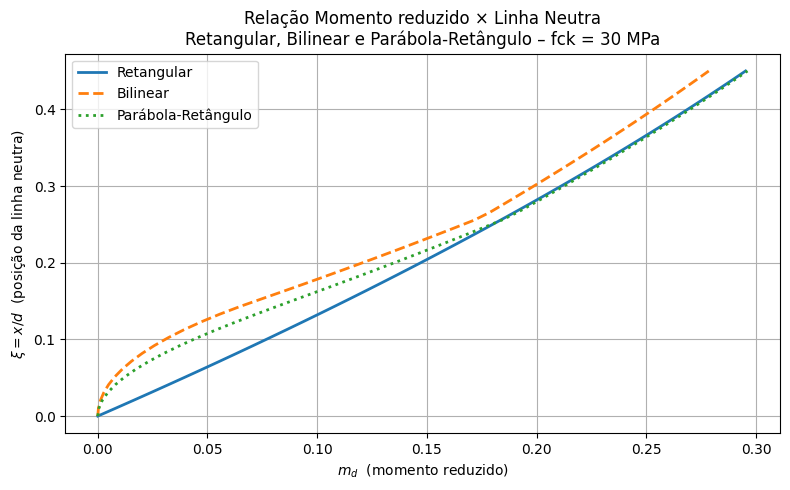

In [49]:
# ----------------------------------------------------------------------
# Função do momento reduzido m_d(x) para o diagrama retangular
# ----------------------------------------------------------------------
def md_reta(x, fck):
    if fck <= 50:
        lbd = 0.80
    else:
        lbd = 0.80 - ((fck - 50) / 400)
    mi_reta = lbd * x * (1 - 0.5 * lbd * x)
    return mi_reta

# ----------------------------------------------------------------------
# Função do momento reduzido m_d(x) para o diagrama bilinear
# ----------------------------------------------------------------------
def md_bili(x, fck):
    # parâmetros do diagrama bilinear
    if fck <= 50.0:
        e01 = 1.75   # ‰ – início do patamar
        eu  = 3.50   # ‰ – deformação última
    else:
        e01 = 1.75 + 0.55 * (fck - 50.0) / 40.0
        eu  = 2.6 + 35.0 * ((90.0 - fck) / 100.0)**4

    # proteção para valores extremos de x
    if x <= 0.0:
        return 0.0
    if x >= 1.0:
        x = 0.999999

    # discretização da altura comprimida
    y = np.linspace(0.0, x, 2000)

    # posição limite em que a fibra de compressão atinge eu
    x23 = eu / (eu + 10.0)

    # campo de deformações (mesma cinemática usada na parábola)
    if x < x23:
        ec = 10.0 * (x - y) / (1.0 - x)
    else:
        ec = eu * (1.0 - y / x)

    # só interessa compressão
    ec = np.where(ec > 0.0, ec, 0.0)

    # diagrama bilinear: trecho linear até e01, patamar constante depois
    ec_eff = np.minimum(ec, e01)      # corta em e01
    sig_tilde = ec_eff / e01          # σ̃ = εc / e01  (→ 1 para εc ≥ e01)

    tconc = sig_tilde

    # integração numérica do momento reduzido em relação à borda tracionada
    m_tilde = np.trapezoid(tconc * (1.0 - y), y)

    return m_tilde

# ----------------------------------------------------------------------
# Função do momento reduzido m_d(x) para o diagrama parábola-retângulo
# ----------------------------------------------------------------------
def md_para(x, fck):
    if fck <= 50.0:
        ec2 = 2.0     # ‰ – fim da parábola
        eu  = 3.5     # ‰ – deformação última
        n   = 2.0
    else:
        eo  = 2.0 + 0.085 * (fck - 50.0)**0.53
        eu  = 2.6 + 35.0 * ((90.0 - fck)/100.0)**4
        n   = 1.4 + 23.4 * ((90.0 - fck)/100.0)**4
        ec2 = eo

    if x <= 0.0:
        return 0.0
    if x >= 1.0:
        x = 0.999999

    y = np.linspace(0.0, x, 2000)
    x23 = eu / (eu + 10.0)

    if x < x23:
        ec = 10.0 * (x - y) / (1.0 - x)
    else:
        ec = eu * (1.0 - y / x)

    ec = np.where(ec > 0.0, ec, 0.0)
    ec_eff = np.minimum(ec, ec2)
    sig_tilde = 1.0 - (1.0 - ec_eff/ec2)**n
    tconc = sig_tilde
    m_tilde = np.trapezoid(tconc * (1.0 - y), y)

    return m_tilde

# ----------------------------------------------------------------------
# Geração do Gráfico para Comparação
# ----------------------------------------------------------------------
fck = 30.0                          # concreto de referência
x_vals = np.linspace(0.0, 0.45, 45) # 45 valores em ξ = x/d

md_vals_reta  = md_reta(x_vals, fck)
md_vals_bili  = np.array([md_bili(x, fck) for x in x_vals])
md_vals_para  = np.array([md_para(x, fck) for x in x_vals])

plt.figure(figsize=(8, 5))

plt.plot(md_vals_reta, x_vals, label="Retangular", linewidth=2)
plt.plot(md_vals_bili, x_vals, label="Bilinear", linewidth=2, linestyle="--")
plt.plot(md_vals_para, x_vals, label="Parábola-Retângulo", linewidth=2, linestyle=":")

plt.xlabel(r"$m_d$  (momento reduzido)")
plt.ylabel(r"$\xi = x/d$  (posição da linha neutra)")
plt.title(f"Relação Momento reduzido × Linha Neutra\nRetangular, Bilinear e Parábola-Retângulo – fck = {fck:.0f} MPa")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
